# Graduate Admission Prediction

# Cài đặt, import các thư viện và dataset

In [3]:
!pip install numpy pandas scikit-learn matplotlib seaborn torch kagglehub xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   - -------------------------------------- 4.7/150.0 MB 37.9 MB/s eta 0:00:04
   -- ------------------------------------- 9.4/150.0 MB 30.2 MB/s eta 0:00:05
   --- ------------------------------------ 14.9/150.0 MB 28.3 MB/s eta 0:00:05
   ------- -------------------------------- 27.5/150.0 MB 39.0 MB/s eta 0:00:04
   ---------- ----------------------------- 39.8/150.0 MB 43.1 MB/s eta 0:00:03
   ------------- -------------------------- 52.4/150.0 MB 46.2 MB/s eta 0:00:03
   ---------------- ----------------------- 61.1/150.0 MB 45.7 MB/s eta 0:00:02
   ----------------- ---------------------- 65.5/150.0 MB 42.4 MB/s eta 0:00:02
   ------------------ --------------------- 70.0/150.0 MB 40.1 MB/s eta 0:00:02
   ------------------- -------------------- 74.7/150.0 MB 38.2 MB/s eta 0:00:02
   --------------------- ------------------ 79.2/150.0 MB 36.9 MB/s eta 0:00:02
   ---------------------- ----------------- 83.9/15

In [4]:
# Code để tải dataset từ Kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohansacharya/graduate-admissions")

print("Path to dataset files:", path)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 9.64k/9.64k [00:00<00:00, 11.6MB/s]

Extracting files...
Path to dataset files: C:\Users\Admin\.cache\kagglehub\datasets\mohansacharya\graduate-admissions\versions\2


In [ ]:
# Import các thư viện

import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import ParameterGrid

warnings.filterwarnings('ignore')
random_state = 42
test_size = 0.2

# I. Exploratory Data Analysis

## 1. Giới thiệu và lựa chọn dữ liệu
#### Nguồn gốc của tập dữ liệu:
* Bộ dữ liệu được lấy từ [Kaggle](https://www.kaggle.com/datasets/mohansacharya/graduate-admissions/data?select=Admission_Predict_Ver1.1.csv).
* Được tổng hợp từ dữ liệu tuyển sinh của các trường đại học tại Hoa Kỳ.
* Mục đích: Giúp sinh viên hoặc nhà tuyển sinh phân tích, dự đoán khả năng trúng tuyển dựa trên hồ sơ đầu vào.

#### Mô tả chung về bộ dữ liệu:
Bộ dữ liệu gồm thông tin về 500 ứng viên, với các đặc trưng liên quan đến kết quả học tập, chứng chỉ và kinh nghiệm làm việc. Cột mục tiêu là Chance of Admit – biểu thị xác suất được nhận vào chương trình cao học.

## 2. Khám phá dữ liệu (EDA) 

### 2.1 Đọc dữ liệu và khám phá tổng quan

In [6]:
# Đọc dataset và loại bỏ khoảng trắng tên cột của dataset.
df = pd.read_csv(path + '/Admission_Predict_Ver1.1.csv', index_col='Serial No.')
df.columns = [x.strip() for x in df.columns]
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65


In [ ]:
df.shape

(500, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 1 to 500
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 35.2 KB


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.nunique()

,0
GRE Score,49
TOEFL Score,29
University Rating,5
SOP,9
LOR,9
CGPA,184
Research,2
Chance of Admit,61


#### Thông tin Dataset

#### Dataset gồm **9 cột**, chi tiết như sau:

| Tên cột                  | Ý nghĩa                                                        | Kiểu dữ liệu | Dạng dữ liệu               |
| ------------------------ | ------------------------------------------------------  | ------------ | -------------------------- |
| **Serial No.**           | Số thứ tự ứng viên                                     | ---               | int64        | Định danh                  |
| **GRE Score**            | Điểm thi GRE (Graduate Record Examinations)                | int64        | Số nguyên                  |
| **TOEFL Score**          | Điểm thi TOEFL (Test of English as a Foreign Language)           | int64        | Số nguyên                  |
| **University Rating**    | Xếp hạng trường ứng viên nộp hồ sơ                                | int64        | Số nguyên (rời rạc)        |
| **SOP**                  | Mức độ ấn tượng của Statement of Purpose                       | float64      | Số thực                    |
| **LOR**             | Chất lượng thư giới thiệu (Letter of Recommendation)          | float64      | Số thực                    |
| **CGPA**                 | Điểm trung bình đại học (Cumulative GPA)                   | float64      | Số thực                    |
| **Research**             | Kinh nghiệm nghiên cứu khoa học (0 = Không, 1 = Có)                        | int64        | Nhị phân (0/1)             |
| **Chance of Admit** | Xác suất được nhận vào (cột mục tiêu)                          | float64      | Số thực (giá trị liên tục) |



In [ ]:
columns = list(df.columns)
categorical_cols = []
numerical_cols = []
for i in columns:
    if len(df[i].unique()) > 5:
        numerical_cols.append(i)
    else:
        categorical_cols.append(i)
print('Numerical features: ', numerical_cols)
print('Categorical features: ', categorical_cols)

Numerical features:  ['GRE Score', 'TOEFL Score', 'SOP', 'LOR', 'CGPA', 'Chance of Admit']
Categorical features:  ['University Rating', 'Research']


### 2.2 Thống kê mô tả và trực quan hóa các biến numerical

In [8]:
numerical_cols = ['GRE Score', 'TOEFL Score', 'SOP', 'LOR', 'CGPA', 'Chance of Admit']
categorical_cols = ['University Rating', 'Research']

In [ ]:
df[numerical_cols].describe()

,GRE Score,TOEFL Score,SOP,LOR,CGPA,Chance of Admit
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.00000
mean,316.472000,107.192000,3.374000,3.48400,8.576440,0.72174
std,11.295148,6.081868,0.991004,0.92545,0.604813,0.14114
min,290.000000,92.000000,1.000000,1.00000,6.800000,0.34000
25%,308.000000,103.000000,2.500000,3.00000,8.127500,0.63000
50%,317.000000,107.000000,3.500000,3.50000,8.560000,0.72000
75%,325.000000,112.000000,4.000000,4.00000,9.040000,0.82000
max,340.000000,120.000000,5.000000,5.00000,9.920000,0.97000


#### Nhận xét:
1. GRE Score:
* mean = 316.47
* std = 11.30: tương đối nhỏ, dữ liệu tập trung
* Khoảng giá trị từ 290 đến 340
* Phần lớn ứng viên đạt điểm GRE khá cao, mức điểm tập trung nhiều quanh mức trung bình 316–317.

2. TOOEFL Score:
* mean = 107.19
* Khoảng giá trị: từ 92 đến 120
* TOEFL của ứng viên cũng khá cao, với phần lớn đạt từ 100 trở lên.

3. SOP:
* mean = 3.37 (trên thang 5)
* std = 0.99 nhỏ
* Chất lượng bài luận SOP phần lớn ở mức trung bình khá đến khá tốt (điểm SOP phân bố khá đều).

4. LOR:
* mean = 3.48 (trên thang 5)
* std = 0.93
* Tương tự SOP, thư giới thiệu của đa số ứng viên đạt mức trung bình khá.

5. CGPA:
* mean = 8.58 (thang 10)
* Khoảng: từ 6.80 đến 9.92
* Điểm GPA cao, đa phần ứng viên có học lực khá đến giỏi.

6. Chance of Admit (Biến mục tiêu)
* mean = 0.72
* Khoảng: từ 0.34 đến 0.97
* Phần lớn ứng viên có khả năng trúng tuyển từ 70% trở lên. Có một số ứng viên chỉ có ~34% cơ hội trúng tuyển, nhưng số lượng này ít.

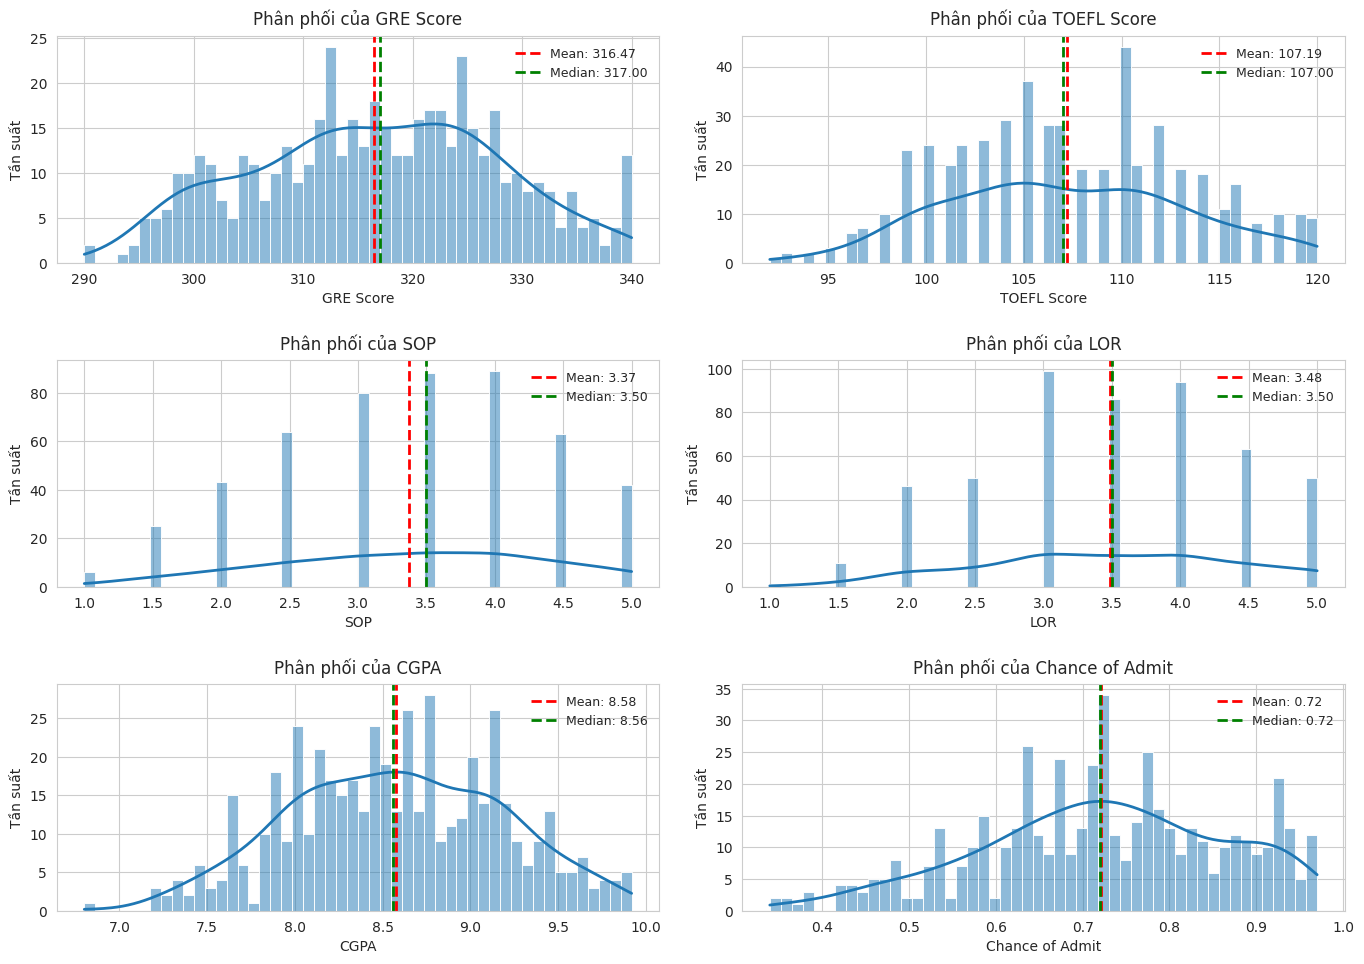

In [ ]:
stats = df[numerical_cols].describe()
stats.loc['variance'] = df[numerical_cols].var()

plt.figure(figsize=(14, 10))

for i, col in enumerate(numerical_cols):
    plt.subplot(3, 2, i+1)
    sns.histplot(df[col], kde=True, bins=50, line_kws={'linewidth': 2})
    plt.title(f'Phân phối của {col}', fontsize=12, pad=8)
    plt.axvline(df[col].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {df[col].mean():.2f}')
    plt.axvline(df[col].median(), color='green', linestyle='dashed', linewidth=2, label=f'Median: {df[col].median():.2f}')
    plt.legend(fontsize=9, loc='best', frameon=False)
    plt.xlabel(col)
    plt.ylabel('Tần suất')

plt.tight_layout(pad=2.0)
plt.show()

#### Nhận xét:
1. GRE Score
* Trung bình: ~316.5, trung vị: ~317 → gần nhau → phân phối khá đối xứng.
* Phân phối dạng chuông hơi lệch trái nhẹ.
* Phổ điểm: từ ~290 đến ~340 → đa số tập trung quanh 310–330.

2. TOEFL Score
* Trung bình: ~107.2, trung vị: ~107 → phân phối gần đối xứng.
* Phổ điểm từ ~90 đến 120.
* Dạng phân phối khá cân đối, nhưng có một số điểm thấp (nhỏ hơn 95) xuất hiện ít.

3. SOP (Statement of Purpose)
* Trung bình: ~3.37, trung vị: ~3.5 → có phần lệch trái nhẹ (phần lớn điểm cao hơn).
* Phân phối không liên tục (dạng rời rạc) → biến rời rạc hoặc đánh giá theo thang điểm.
* Tập trung nhiều quanh 3.5 đến 4.

4. LOR (Letter of Recommendation)
* Trung bình và trung vị: đều khoảng 3.5 → đối xứng tốt.
* Phân phối rời rạc, phổ biến nhất là ~3.5.
* Cũng được chấm theo thang điểm như SOP.

5. CGPA
* Trung bình: 8.58, trung vị: 8.56 → rất gần nhau → phân phối gần đối xứng.
* Phân phối hơi lệch trái nhẹ (một số sinh viên CGPA rất cao ~10).
* Dạng phân phối gần chuẩn (Gaussian).

6. Chance of Admit
* Trung bình và trung vị: ~0.72 → phân phối gần đối xứng.
* Phân phối lệch trái nhẹ (nhiều sinh viên có khả năng trúng tuyển cao hơn).
* Phổ rộng: từ 0.4 đến 1.0, tập trung mạnh ở ~0.7–0.8.

### 2.3 Thống kê mô tả và trực quan hóa các biến categorical


Cột: University Rating


,Số lượng,Tỷ lệ (%)
University Rating,,
3,162,32.4
2,126,25.2
4,105,21.0
5,73,14.6
1,34,6.8


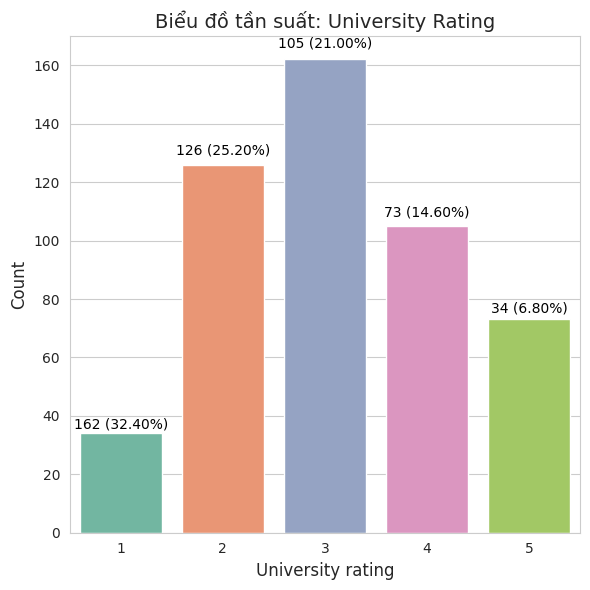


Cột: Research


,Số lượng,Tỷ lệ (%)
Research,,
1,280,56.0
0,220,44.0


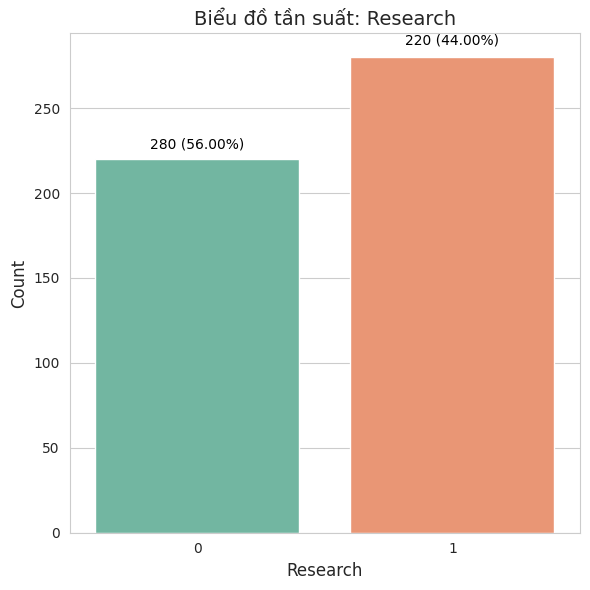

In [ ]:
def print_categorical_summary(df, col):
    counts = df[col].value_counts()
    percents = df[col].value_counts(normalize=True) * 100

    summary = pd.DataFrame({
        'Số lượng': counts.values,
        'Tỷ lệ (%)': percents.round(2)
    })

    return summary
for col in categorical_cols:
    print(f"\nCột: {col}")
    temp = print_categorical_summary(df, col)
    display(temp)

    sns.set_style("whitegrid")

    plt.figure(figsize=(6, 6))
    ax = sns.countplot(x=col, data=df, palette='Set2')

    plt.title(f"Biểu đồ tần suất: {col}", fontsize=14)
    plt.xlabel(col.capitalize(), fontsize=12)
    plt.ylabel('Count', fontsize=12)

    for i, p in enumerate(ax.patches):
        count = temp.iloc[i]['Số lượng']
        percent = temp.iloc[i]['Tỷ lệ (%)']
        x = p.get_x() + p.get_width() / 2.
        y = p.get_height()
        ax.text(x, y + y * 0.02,
                f'{int(count)} ({percent:.2f}%)',
                ha='center', va='bottom',
                fontsize=10, color='black')

    plt.tight_layout()
    plt.show()

#### Nhận xét:
1. University Rating
* Phần lớn ứng viên đến từ các trường xếp hạng 3 (chiếm 32.4%) và 2 (25.2%).
* Trường xếp hạng 4 và 5 ít hơn, nhưng vẫn có số lượng đáng kể (tổng cộng 35.6%).
* Trường xếp hạng 1 là thiểu số, chỉ chiếm khoảng 6.8%.

=> Dữ liệu bị lệch về phía trường trung bình khá (xếp hạng 3). Do đó, biến này mang tính phân loại rời rạc không đều, cần lưu ý khi đưa vào mô hình.

2. Research
* Hơn một nửa ứng viên (56%) có kinh nghiệm nghiên cứu khoa học.
* Tuy nhiên, vẫn có 44% chưa từng nghiên cứu.

=> Biến Research có phân phối khá cân bằng (không quá lệch), phù hợp để mô hình học hỏi phân biệt.

### 2.4 Thống kê và trực quan hóa outlier

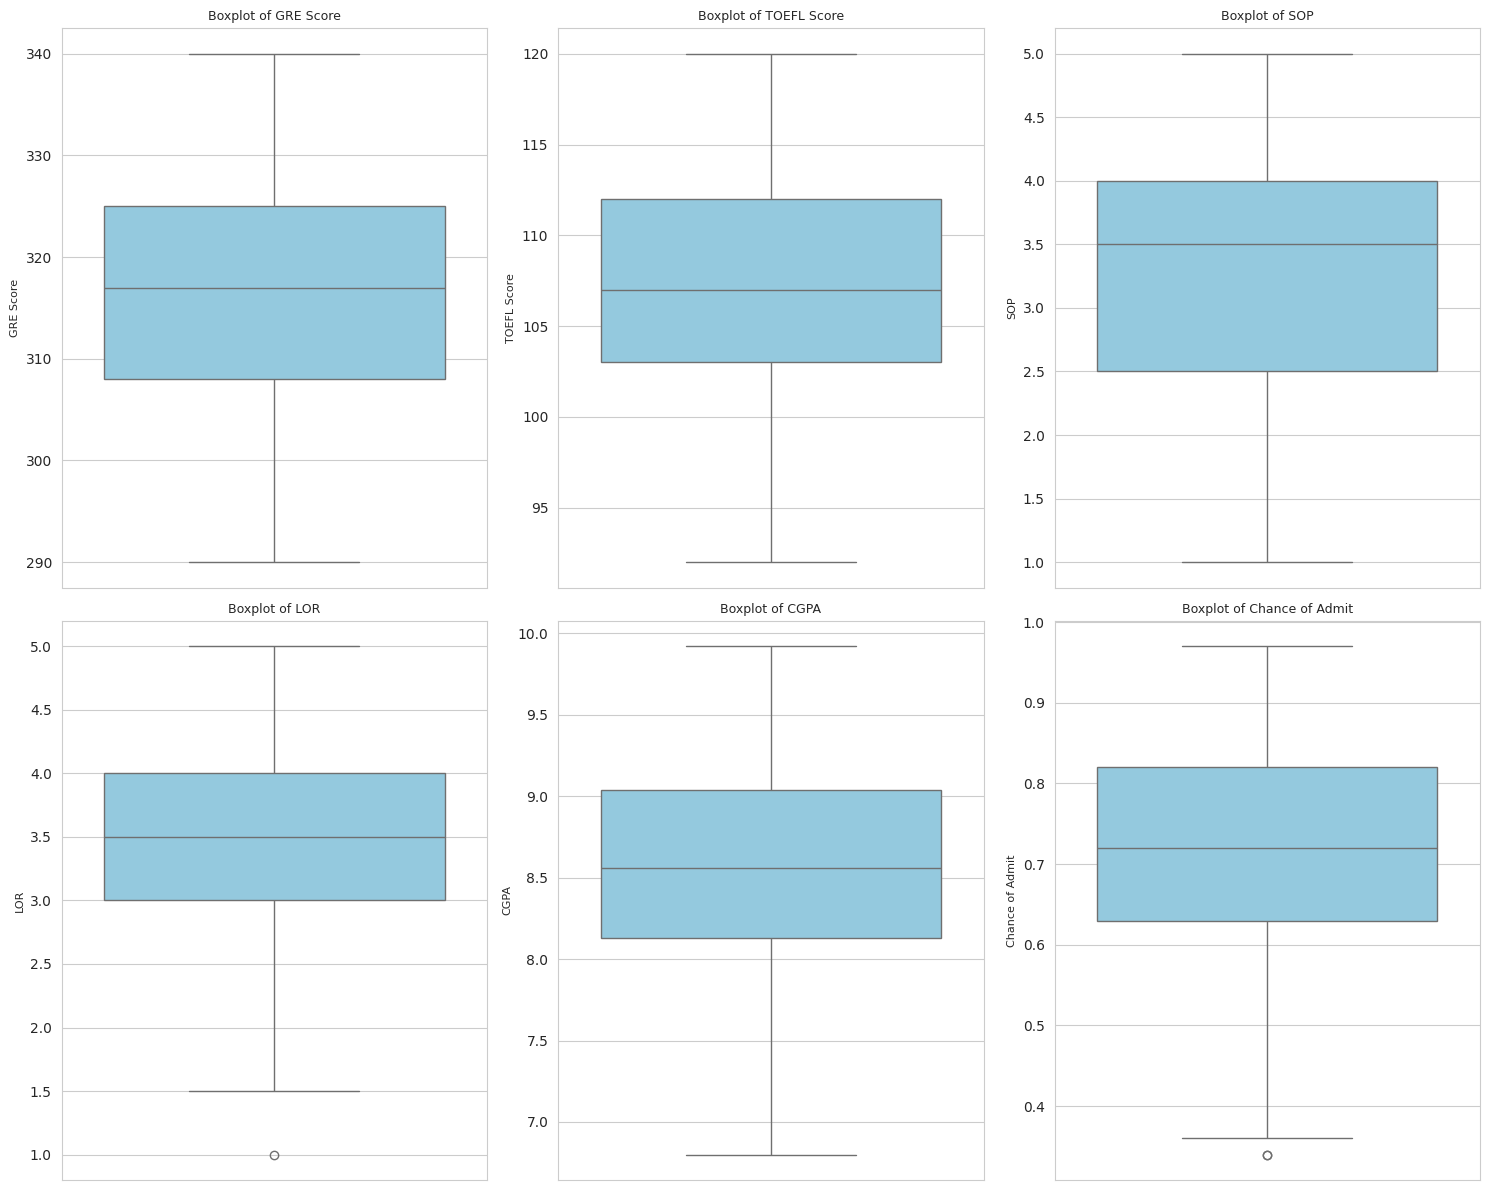

In [ ]:
n_cols = 3
n_rows = math.ceil(len(numerical_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, y=col, color="skyblue", ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}', fontsize=9)
    axes[i].set_ylabel(col, fontsize=8)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def count_outliers_iqr(df, columns):
    outlier_dict = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_count = df[(df[col] < lower) | (df[col] > upper)].shape[0]
        outlier_dict[col] = outlier_count
    return outlier_dict
outlier_counts = count_outliers_iqr(df, numerical_cols)
outlier_df = pd.DataFrame(list(outlier_counts.items()), columns=['Thuộc tính', 'Số lượng outliers'])
display(outlier_df)

,Thuộc tính,Số lượng outliers
0,GRE Score,0
1,TOEFL Score,0
2,SOP,0
3,LOR,1
4,CGPA,0
5,Chance of Admit,2


#### Nhận xét:
1. GRE Score
* IQR hẹp, tập trung quanh 310–325.
* Không có outlier rõ ràng.
* Phân phối khá cân đối → phù hợp với các mô hình nhạy cảm với outlier như hồi quy tuyến tính.

2. TOEFL Score
* IQR nằm trong khoảng 104–112.
* Một vài điểm thấp hơn 95 → có outlier nhẹ ở phía thấp.
* Phân phối nhìn chung vẫn đều và không bị lệch quá nhiều.

3. SOP
* Dữ liệu nằm trong khoảng 1–5 (thang điểm).
* IQR rơi vào khoảng 2.5–4.
* Không có outlier.
* Phân phối đều, rời rạc, có thể do thang đánh giá.

4. LOR
* IQR trong khoảng 3–4.
* Có một outlier duy nhất ở mức ~1.0.
* Dữ liệu nhìn chung cân đối, nhưng một số ít LOR bị đánh giá rất thấp.

5. CGPA
* IQR khoảng 8.2–9.2, rất tập trung.
* Không có outlier mạnh.
* Phân phối đẹp, gần chuẩn, phù hợp dùng làm biến đầu vào cho mô hình ML.

6. Chance of Admit
* IQR khoảng 0.65–0.82.
* Có một số outlier thấp (~0.4).
* Mặc dù vậy, dữ liệu phân phối vẫn khá hợp lý và không có sự lệch lớn.

### 2.5 Phân tích mối quan hệ giữa các biến numerical

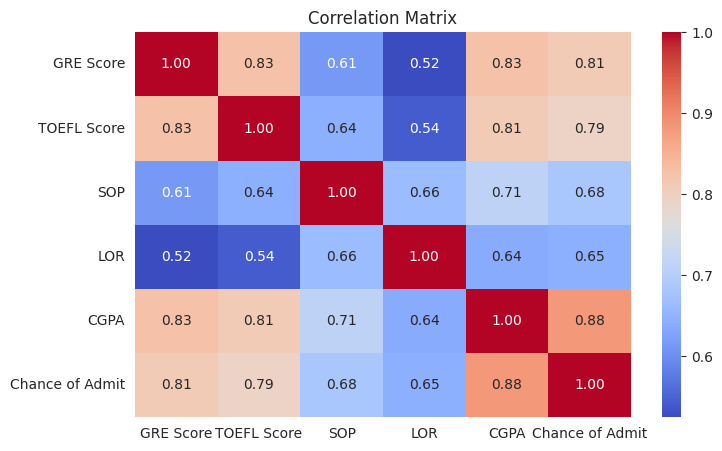

In [ ]:
plt.figure(figsize=(8, 5))
corr = df[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### Nhận xét:
1. Tương quan với biến mục tiêu:

| Biến            | Hệ số tương quan với `Chance of Admit` | Nhận xét                                                   |
| --------------- | -------------------------------------- | ---------------------------------------------------------- |
| **CGPA**        | **0.88**                               | **Tương quan mạnh nhất** – CGPA là yếu tố dự đoán chính |
| **GRE Score**   | 0.81                                   | Tương quan mạnh                                            |
| **TOEFL Score** | 0.79                                   | Tương quan cao                                             |
| **SOP**         | 0.68                                   | Tương quan trung bình–khá                                  |
| **LOR**         | 0.65                                   | Tương quan trung bình                                      |

* CGPA là yếu tố ảnh hưởng lớn nhất đến khả năng được nhận.

* GRE và TOEFL cũng có vai trò đáng kể.

* SOP & LOR có vai trò vừa phải, nhưng vẫn nên giữ lại vì có thông tin bổ sung.

2. Tương quan giữa các biến độc lập:

| Cặp biến     | Hệ số tương quan | Nhận xét                                             |
| ------------ | ---------------- | ---------------------------------------------------- |
| GRE – TOEFL  | **0.83**         | **Tương quan rất cao**, có thể hơi dư thừa thông tin |
| GRE – CGPA   | 0.83             | Cũng rất cao                                         |
| TOEFL – CGPA | 0.81             | Rất cao                                              |
* GRE, TOEFL, CGPA có liên hệ rất mạnh với nhau → Nếu dùng mô hình nhạy với đa cộng tuyến (như hồi quy tuyến tính), có thể cần xử lý (PCA, loại bớt biến, regularization).

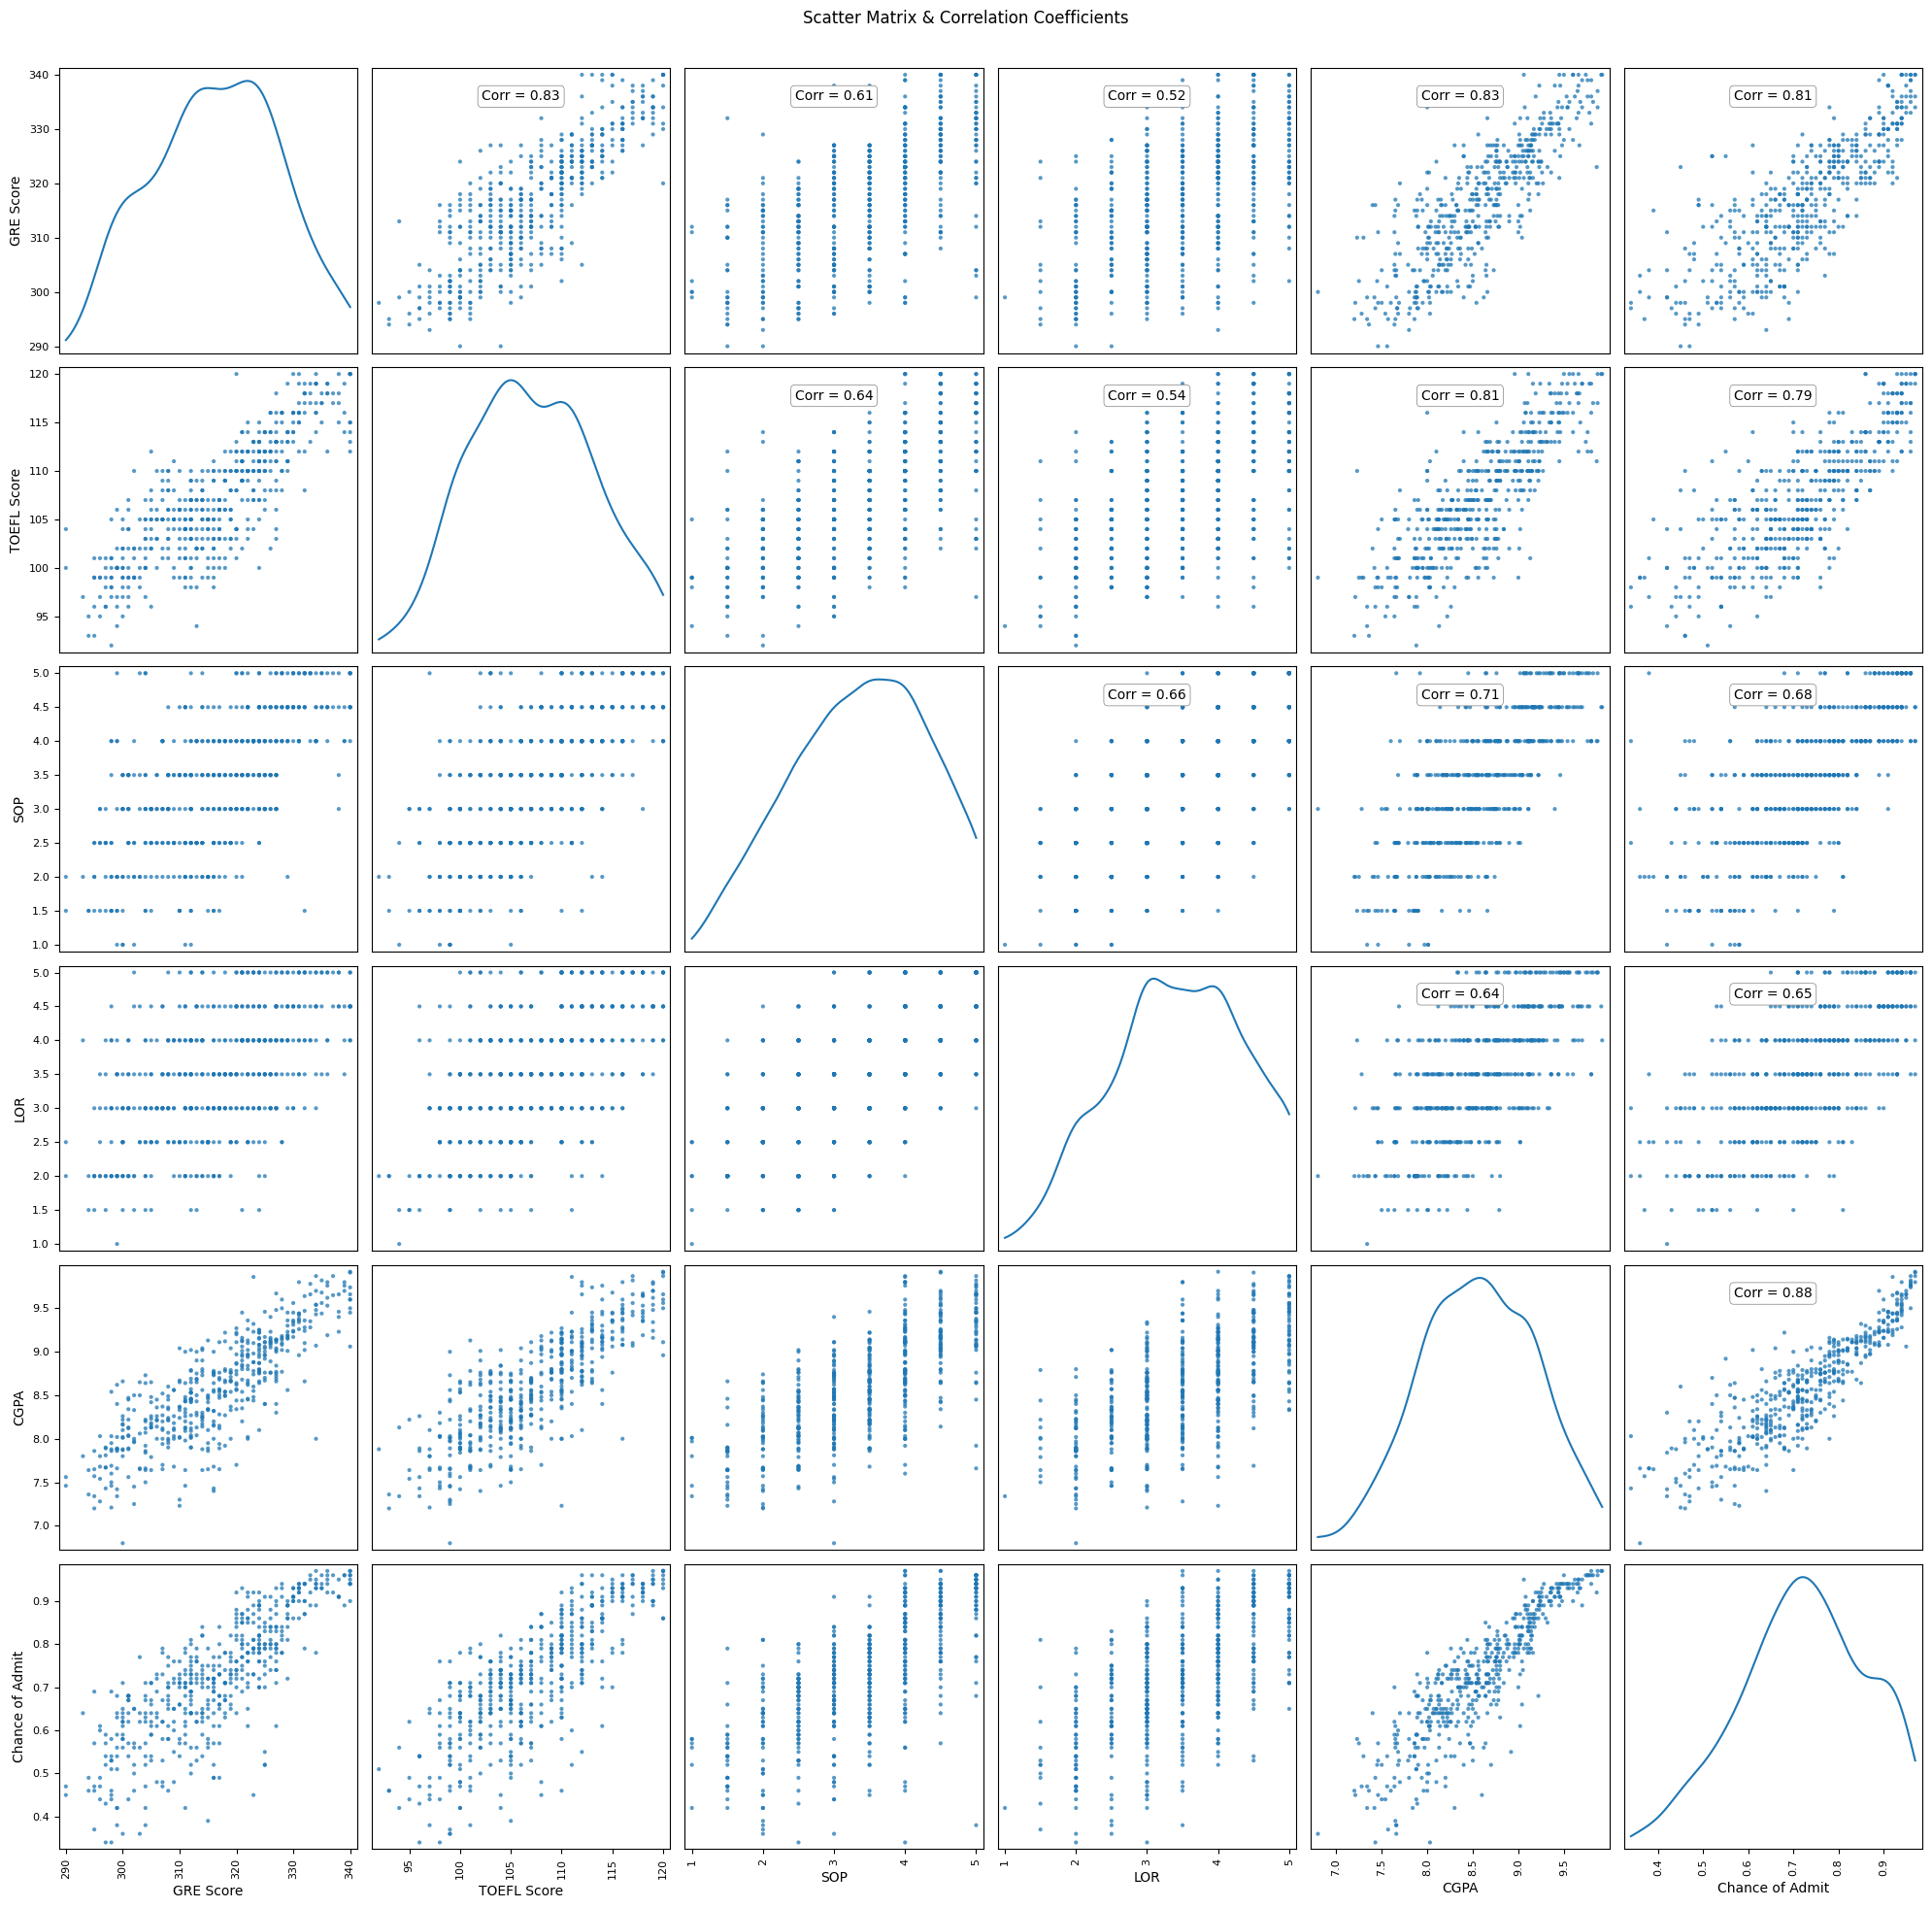

In [9]:
def plotScatterMatrix(df, numerical_cols, plotSize=15, textSize=10):
    df = df[numerical_cols]
    df = df[[col for col in df.columns if df[col].nunique() > 1]]

    if len(df.columns) > 10:
        df = df.iloc[:, :10]

    ax_array = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=(plotSize, plotSize), diagonal='kde')

    # Tính ma trận tương quan
    corrs = df.corr().values
    n = len(df.columns)

    for i in range(n):
        for j in range(n):
            if i < j:
                ax = ax_array[i, j]
                ax.annotate(f"Corr = {corrs[i, j]:.2f}",
                            xy=(0.5, 0.9), xycoords='axes fraction',
                            ha='center', va='center', fontsize=textSize,
                            bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', lw=0.5))

    plt.suptitle('Scatter Matrix & Correlation Coefficients', size=textSize + 2)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

plotScatterMatrix(df,numerical_cols, 20, 10)

### 2.6 Phân tích mối quan hệ giữa biến numerical và biến categorical

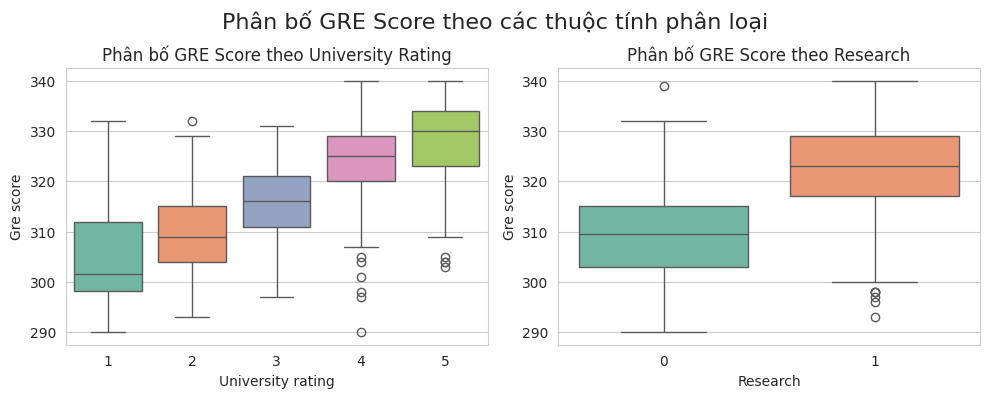

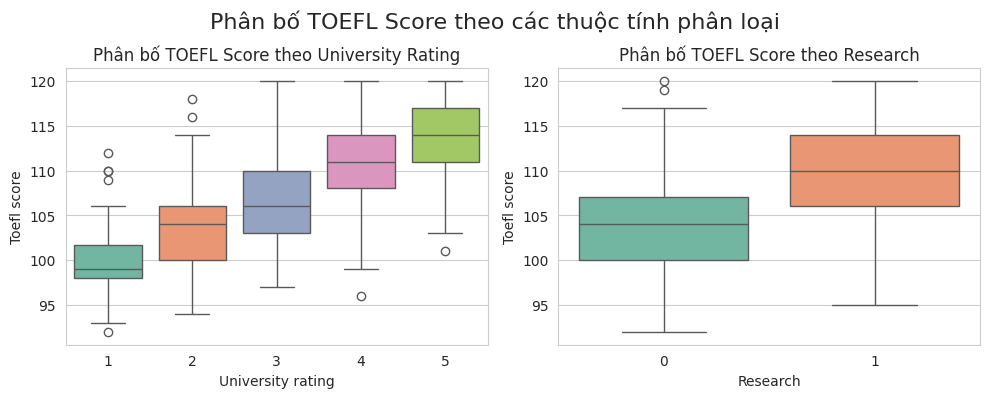

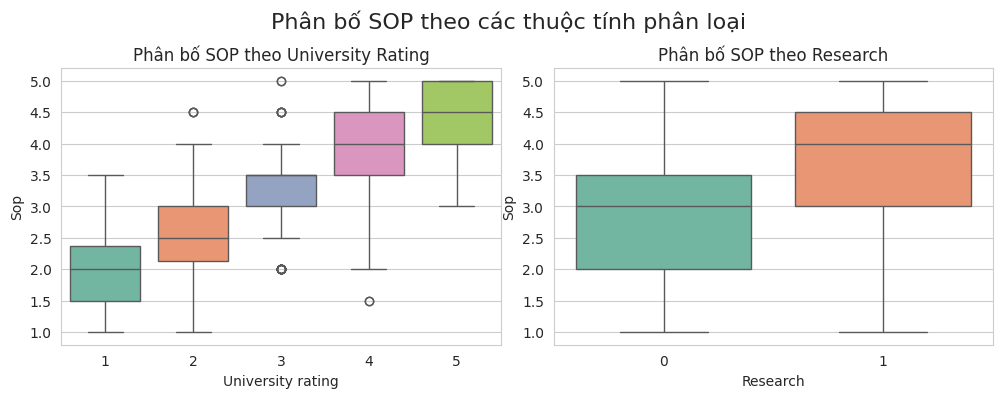

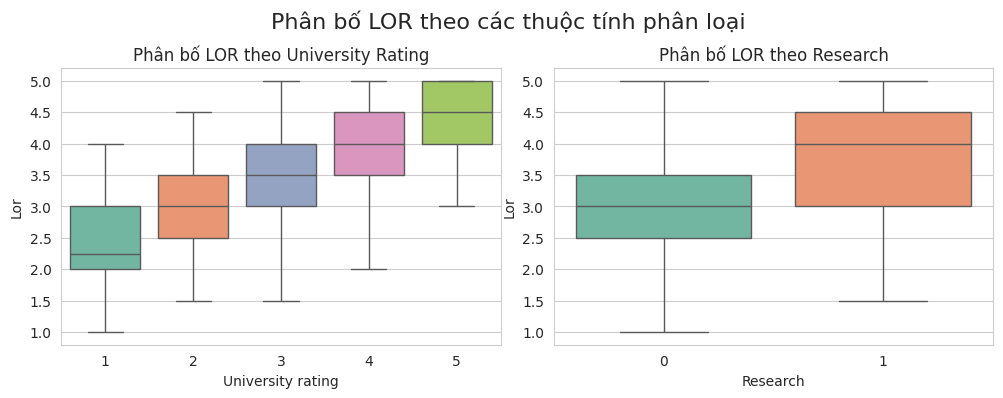

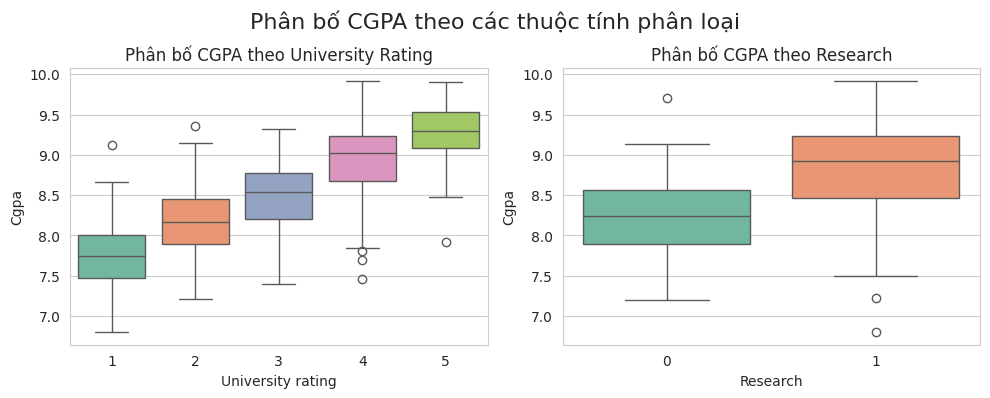

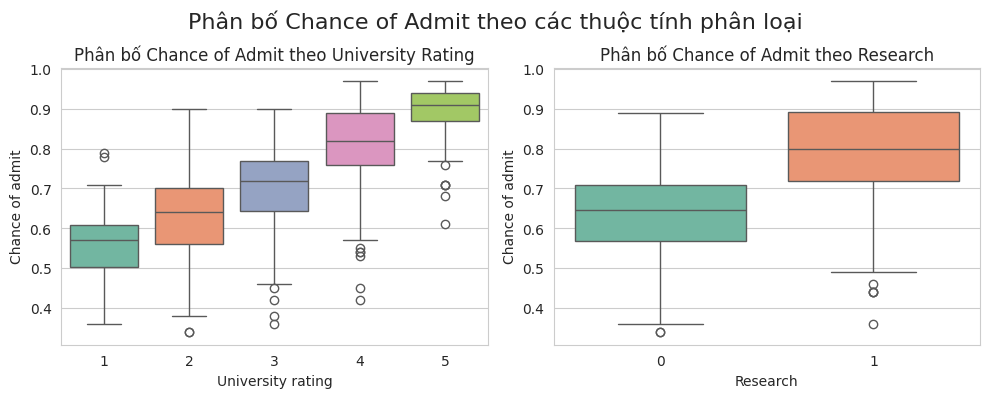

In [ ]:
def plot_numerical_by_categorical_boxplot(df, numerical_col, categorical_cols, palette='Set2'):
    sns.set_style("whitegrid")
    n_cols = 2
    n_rows = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
    axes = axes.flatten()

    for idx, cat_col in enumerate(categorical_cols):
        ax = axes[idx]
        sns.boxplot(data=df, x=cat_col, y=numerical_col, palette=palette, ax=ax)
        ax.set_title(f'Phân bố {numerical_col} theo {cat_col}')
        ax.set_xlabel(cat_col.capitalize())
        ax.set_ylabel(numerical_col.capitalize())
        ax.tick_params(axis='x')

    for j in range(len(categorical_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle(f'Phân bố {numerical_col} theo các thuộc tính phân loại', fontsize=16, y=1.02)
    plt.show()

for col in numerical_cols:
    plot_numerical_by_categorical_boxplot(df, numerical_col=col, categorical_cols=categorical_cols)

#### Nhận xét:
1. GRE Score vs University Rating

Nhận xét: GRE Score tăng dần theo mức University Rating. Trường có rating cao thường có sinh viên GRE trên 320.

=> University Rating cao yêu cầu GRE cao hơn.

2. TOEFL Score vs University Rating

Nhận xét: TOEFL Score cũng tăng theo University Rating, nhưng mức độ biến thiên nhỏ hơn so với GRE.

=> Trường tốt thường yêu cầu TOEFL cao hơn, nhưng không khắt khe như GRE.

3. SOP vs University Rating

Nhận xét: SOP có xu hướng tăng nhẹ theo Rating. Trường top có nhiều ứng viên với SOP ≥ 4.

=> SOP được đánh giá cao hơn ở các trường có thứ hạng cao.

4. LOR vs University Rating

Nhận xét: Giống SOP, LOR cũng tăng theo Rating, nhất là ở mức Rating 4-5.

=> Thư giới thiệu (LOR) đóng vai trò quan trọng hơn ở các trường top.

5. CGPA vs University Rating
Nhận xét: CGPA có xu hướng tăng rõ rệt theo Rating, đặc biệt từ Rating 3 trở lên.

=> Trường xếp hạng cao đòi hỏi CGPA cao hơn.

6. Chance of Admit vs University Rating

Nhận xét: Tỉ lệ được nhận tăng theo Rating. Rating 5 có median chance of admit > 0.8.

=> Trường tốt thường chỉ nhận hồ sơ mạnh nên tỷ lệ được nhận cao nếu đạt yêu cầu.

7. So sánh theo Research = 0 và 1

* GRE, TOEFL, SOP, LOR, CGPA, Chance of Admit đều cao hơn rõ rệt khi Research = 1.

=> Kinh nghiệm nghiên cứu (Research = 1) là một yếu tố giúp tăng khả năng trúng tuyển.
Nó cũng đi kèm với hồ sơ học tập và kỹ năng tốt hơn ở các chỉ số khác.

# II. Các thuật toán

## 1. Simple Linear Regression 

In [ ]:
df.columns = df.columns.str.strip()

target = 'Chance of Admit'
x = df[['CGPA']]
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

num_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, ['CGPA'])
])

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 0.0630
MAE: 0.0446
R²: 0.8060


In [ ]:
regressor = model.named_steps['regressor']

print('Coefficients:', regressor.coef_)
print('Intercept:', regressor.intercept_)

Coefficients: [0.12327562]
Intercept: 0.7241749999999999


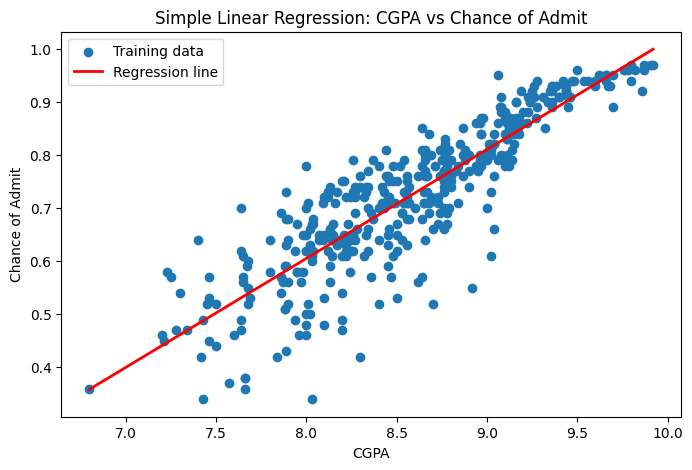

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(x_train, y_train, label='Training data')

x_line = np.linspace(x_train.min(), x_train.max(), 100).reshape(-1, 1)
x_line_df = pd.DataFrame(x_line, columns=['CGPA'])
y_line = model.predict(x_line_df)

plt.plot(x_line, y_line, color='red', linewidth=2, label='Regression line')

plt.xlabel("CGPA")
plt.ylabel("Chance of Admit")
plt.title("Simple Linear Regression: CGPA vs Chance of Admit")
plt.legend()
plt.show()

## 2. Multiple, Polynomial, Ridge, and Lasso Regression 

### a. Multiple Linear Regression

In [ ]:
target = 'Chance of Admit'
x = df.drop(columns=[target], axis=1)
y = df[target]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= test_size, random_state=random_state)
results = []
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

ord_tranformer  = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ("ord", ord_tranformer, ["University Rating"]),
    ("num", num_transformer, ["GRE Score", "TOEFL Score", "SOP", "LOR", "CGPA"])
], remainder='passthrough')

multi_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

multi_model.fit(x_train, y_train)

y_pred = multi_model.predict(x_test)

multi_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
multi_mae = mean_absolute_error(y_test, y_pred)
multi_r2 = r2_score(y_test, y_pred)

results.append({
    "Model": "Multiple Linear Regression",
    "RMSE": multi_rmse,
    "MAE": multi_mae,
    "R2": multi_r2
})

print(f"RMSE: {multi_rmse:.4f}")
print(f"MAE: {multi_mae:.4f}")
print(f"R²: {multi_r2:.4f}")

RMSE: 0.0609
MAE: 0.0427
R²: 0.8188


### b. Polynomial Linear Regression

In [ ]:
degrees = [2, 3, 4]
r2_list = []
for d in degrees:
    poly_model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("poly_features", PolynomialFeatures(degree=d)),
        ("regressor", LinearRegression())
    ])

    poly_model.fit(x_train, y_train)
    y_pred = poly_model.predict(x_test)

    poly_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    poly_mae = mean_absolute_error(y_test, y_pred)
    poly_r2 = r2_score(y_test, y_pred)
    results.append({
      "Model": f"Polynomia Linear Regression (degree = {d})",
      "RMSE": poly_rmse,
      "MAE": poly_mae,
      "R2": poly_r2
    })
    r2_list.append(poly_r2)

    print(f"Degree {d} - R²: {poly_r2:.4f}, RMSE: {poly_rmse:.4f}, MAE: {poly_mae:.4f}")
best_r2 = max(r2_list)
print("The best R2 is:", best_r2)

Degree 2 - R²: 0.8265, RMSE: 0.0596, MAE: 0.0406
Degree 3 - R²: 0.6440, RMSE: 0.0853, MAE: 0.0605
Degree 4 - R²: -10.9375, RMSE: 0.4941, MAE: 0.2451
The best R2 is: 0.8265115552643362


c. Ridge Regression

In [ ]:
ridge_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Ridge(alpha=1))
])

ridge_model.fit(x_train, y_train)
y_pred = ridge_model.predict(x_test)

ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
ridge_mae = mean_absolute_error(y_test, y_pred)
ridge_r2 = r2_score(y_test, y_pred)
results.append({
    "Model": "Ridge Regression",
    "RMSE": ridge_rmse,
    "MAE": ridge_mae,
    "R2": ridge_r2
})

print(f"RMSE: {ridge_rmse:.4f}")
print(f"MAE: {ridge_mae:.4f}")
print(f"R²: {ridge_r2:.4f}")

RMSE: 0.0609
MAE: 0.0427
R²: 0.8188


d. Lasso Regression

In [ ]:
lasso_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Lasso(alpha=0.001))
])

lasso_model.fit(x_train, y_train)
y_pred = lasso_model.predict(x_test)

lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lasso_mae = mean_absolute_error(y_test, y_pred)
lasso_r2 = r2_score(y_test, y_pred)
results.append({
    "Model": "Lasso Regression",
    "RMSE": lasso_rmse,
    "MAE": lasso_mae,
    "R2": lasso_r2
})

print(f"RMSE: {lasso_rmse:.4f}")
print(f"MAE: {lasso_mae:.4f}")
print(f"R²: {lasso_r2:.4f}")

RMSE: 0.0608
MAE: 0.0424
R²: 0.8191


In [ ]:
df_results = pd.DataFrame(results)
df_results

,Model,RMSE,MAE,R2
0,Multiple Linear Regression,0.060866,0.042723,0.818843
1,Polynomia Linear Regression (degree = 2),0.059564,0.040566,0.826512
2,Polynomia Linear Regression (degree = 3),0.085319,0.060507,0.644044
3,Polynomia Linear Regression (degree = 4),0.494086,0.245135,-10.937461
4,Ridge Regression,0.060877,0.042740,0.818779
5,Lasso Regression,0.060823,0.042441,0.819099


## 3. KNN và Weighted KNN 

In [12]:
features_to_scale = ['GRE Score', 'TOEFL Score', 'SOP', 'CGPA', 'LOR']
scaler = MinMaxScaler()
df3 = df.copy()
df3[features_to_scale] = scaler.fit_transform(df3[features_to_scale])

X = df3.drop('Chance of Admit', axis=1)
y = df3['Chance of Admit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

In [15]:
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(weights='uniform'))
])

weighted_knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(weights='distance'))
])

param_grid = {'knn__n_neighbors': list(range(1, 31))}

knn_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
knn_search.fit(X_train, y_train)

weighted_knn_search = GridSearchCV(weighted_knn_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
weighted_knn_search.fit(X_train, y_train)

print("Best n for standard KNN:", knn_search.best_params_['knn__n_neighbors'])
print("Best n for weighted KNN:", weighted_knn_search.best_params_['knn__n_neighbors'])


Best n for standard KNN: 20
Best n for weighted KNN: 20


In [ ]:
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=knn_search.best_params_['knn__n_neighbors'], weights='uniform'))
])
weighted_knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=weighted_knn_search.best_params_['knn__n_neighbors'], weights='distance'))
])

pipelines = {
    'KNN': knn_pipeline,
    'Weighted KNN': weighted_knn_pipeline
}

for name, pipe in pipelines.items():
    pipe.fit(x_train, y_train)
    preds = pipe.predict(x_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    print(f"🔹 {name} Results:")
    print(f"    MAE  = {mae:.4f}")
    print(f"    RMSE = {rmse:.4f}")
    print(f"    R²   = {r2:.4f}")
    print("-" * 35)

🔹 KNN Results:
    MAE  = 0.0476
    RMSE = 0.0666
    R²   = 0.7830
-----------------------------------
🔹 Weighted KNN Results:
    MAE  = 0.0473
    RMSE = 0.0664
    R²   = 0.7843
-----------------------------------


## 4. Decision Trees and Ensemble Methods 


In [ ]:
X = df.drop("Chance of Admit", axis=1)
y = df["Chance of Admit"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [ ]:
param_grid_tree = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}


In [ ]:
models = {
    "Decision Tree": (DecisionTreeRegressor(random_state=42), param_grid_tree),
    "Random Forest": (RandomForestRegressor(random_state=42), param_grid_rf),
    "XGBoost": (XGBRegressor(random_state=42, objective='reg:squarederror'), param_grid_xgb)
}

In [ ]:
results = {}

for name, (model, param_grid) in models.items():
    print(f"{name}")
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=0)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}

    print(f"{name} - Best Params: {grid.best_params_}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  MAE  = {mae:.4f}")
    print(f"  R2   = {r2:.4f}\n")

Decision Tree
Decision Tree - Best Params: {'max_depth': 3, 'min_samples_split': 2}
  RMSE = 0.0731
  MAE  = 0.0508
  R2   = 0.7386

Random Forest
Random Forest - Best Params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
  RMSE = 0.0639
  MAE  = 0.0426
  R2   = 0.8004

XGBoost
XGBoost - Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
  RMSE = 0.0650
  MAE  = 0.0444
  R2   = 0.7933



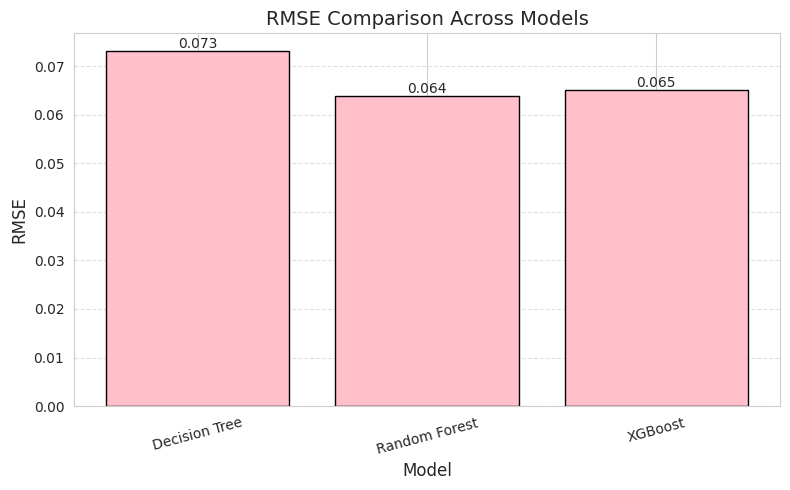

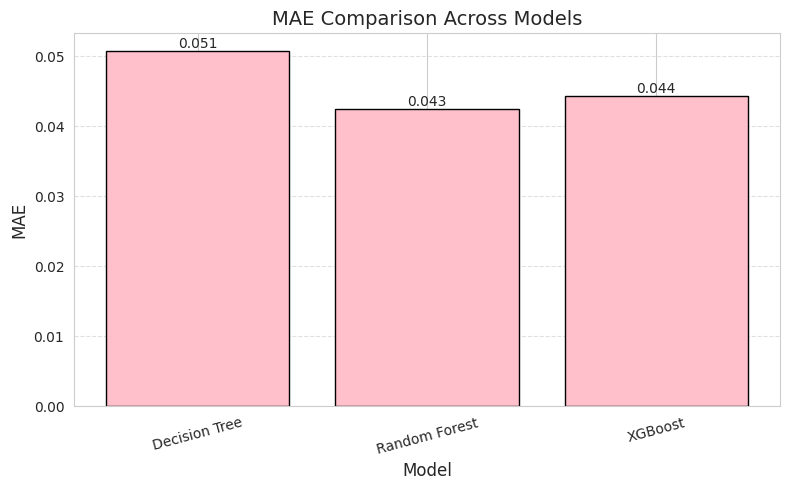

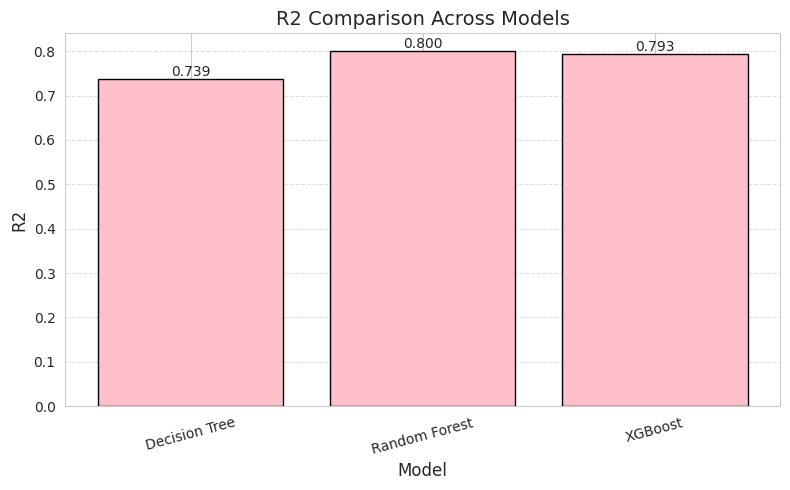

In [ ]:
import matplotlib.pyplot as plt

metrics = ["RMSE", "MAE", "R2"]
model_names = list(results.keys())

for metric in metrics:
    values = [results[model][metric] for model in model_names]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(model_names, values, color='pink', edgecolor='black')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}',
                 ha='center', va='bottom', fontsize=10)

    plt.title(f'{metric} Comparison Across Models', fontsize=14)
    plt.ylabel(metric, fontsize=12)
    plt.xlabel('Model', fontsize=12)
    plt.xticks(rotation=15)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


## 5. SVR và MLP 

### 5.1. SVR: Support Vector Regression

Sử dụng kernel RBF



In [ ]:
X = df.drop(columns=["Chance of Admit"])
y = df["Chance of Admit"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)

svr = SVR(kernel='rbf', C=1, epsilon=0.01, gamma=0.1)
svr.fit(X_train, y_train)

y_pred = svr.predict(X_test)

svr_mae = mean_absolute_error(y_test, y_pred)
svr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
svr_r2 = r2_score(y_test, y_pred)

print("SVR Results:")
print("MAE:", svr_mae)
print("RMSE:", svr_rmse)
print("R² score:", svr_r2)


SVR Results:
MAE: 0.04573919784632197
RMSE: 0.06421335907853319
R² score: 0.7983689249805066


### 5.2. MLP: Multilayer Perceptron

Model có 2 hidden layers, sử dụng ReLU làm activatio function



In [ ]:
X = df.drop(columns=["Chance of Admit"]).values
y = df["Chance of Admit"].values.reshape(-1, 1)

x_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=test_size, random_state=random_state
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

model = nn.Sequential(
    nn.Linear(X_train.shape[1], 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epoches = 500
for epoch in range(epoches):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/500, Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()
    y_pred_rescaled = y_scaler.inverse_transform(y_pred)
    y_test_rescaled = y_scaler.inverse_transform(y_test.numpy())

mlp_mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mlp_rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mlp_r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print("MLP Results:")
print(f"MAE: {mlp_mae:.4f}")
print(f"RMSE: {mlp_rmse:.4f}")
print(f"R² score: {mlp_r2:.4f}")

Epoch 50/500, Loss: 0.4461
Epoch 100/500, Loss: 0.2349
Epoch 150/500, Loss: 0.2159
Epoch 200/500, Loss: 0.2086
Epoch 250/500, Loss: 0.2032
Epoch 300/500, Loss: 0.1989
Epoch 350/500, Loss: 0.1951
Epoch 400/500, Loss: 0.1919
Epoch 450/500, Loss: 0.1890
Epoch 500/500, Loss: 0.1865
MLP Results:
MAE: 0.0440
RMSE: 0.0618
R² score: 0.8132


In [ ]:
comparison_df = pd.DataFrame({
    "Model": ["SVR", "MLP"],
    "MAE": [svr_mae, mlp_mae],
    "RMSE": [svr_rmse, mlp_rmse],
    "R² Score": [svr_r2, mlp_r2]
})

comparison_df

,Model,MAE,RMSE,R² Score
0,SVR,0.045739,0.064213,0.798369
1,MLP,0.044019,0.061805,0.813211


# III. Kết luận

| STT | Mô hình                            | RMSE       | MAE        | R²         |
| --- | ---------------------------------- | ---------- | ---------- | ---------- |
| 0   | Simple Linear Regression           | 0.0630     | 0.0446     | 0.8060     |
| 1   | Multiple Linear Regression         | 0.0609     | 0.0427     | 0.8188     |
| 2   | Polynomial Regression (degree = 2) | **0.0596** | **0.0406** | **0.8265** |
| 3   | Polynomial Regression (degree = 3) | 0.0853     | 0.0605     | 0.6440     |
| 4   | Polynomial Regression (degree = 4) | 0.4941     | 0.2451     | -10.9375   |
| 5   | Ridge Regression                   | 0.0609     | 0.0427     | 0.8188     |
| 6   | Lasso Regression                   | 0.0608     | 0.0424     | 0.8191     |
| 7   | KNN                                | 0.0666     | 0.0476     | 0.7830     |
| 8   | Weighted KNN                       | 0.0664     | 0.0473     | 0.7843     |
| 9   | Decision Tree                      | 0.0731     | 0.0508     | 0.7386     |
| 10  | Random Forest                      | 0.0639     | 0.0426     | 0.8004     |
| 11  | XGBoost                            | 0.0650     | 0.0444     | 0.7933     |
| 12  | Support Vector Regression (SVR)    | 0.0642     | 0.0457     | 0.7984     |
| 13  | Multi-layer Perceptron (MLP)       | 0.0617     | 0.0419 | 0.8136     |

#### Đánh giá và so sánh
* Tốt nhất:
    * Polynomial Regression (degree = 2) đạt kết quả tốt nhất về R² (0.8265), thấp nhất về RMSE và MAE.
    * MLP cũng rất tốt (R² = 0.8136, MAE thấp thứ 2), gần như tương đương.
    * Lasso Regression có hiệu suất rất ổn định, R² = 0.8191.
* Tệ nhất:
    * Polynomial Regression (degree = 4) hoàn toàn bị overfitting, R² âm sâu (-10.93).
    * Polynomial Regression (degree = 3) cũng bắt đầu bị overfit nhẹ.

#### Vấn đề gặp phải
* Overfitting với đa thức bậc cao (degree ≥ 3):

→ RMSE và MAE tăng mạnh, R² giảm, đặc biệt nghiêm trọng với bậc 4.

* Mô hình cây đơn giản (Decision Tree):

→ Hiệu suất kém hơn so với Random Forest/XGBoost do khả năng tổng quát hóa thấp.

* KNN nhạy cảm với scale và phân bố dữ liệu:

→ Cần chuẩn hóa tốt và chọn k hợp lý.
